<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled189.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

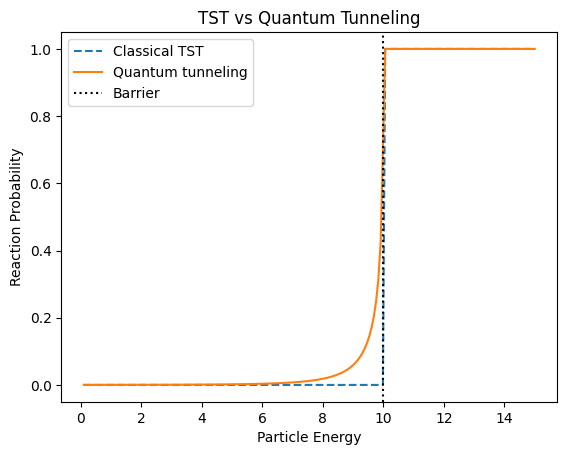

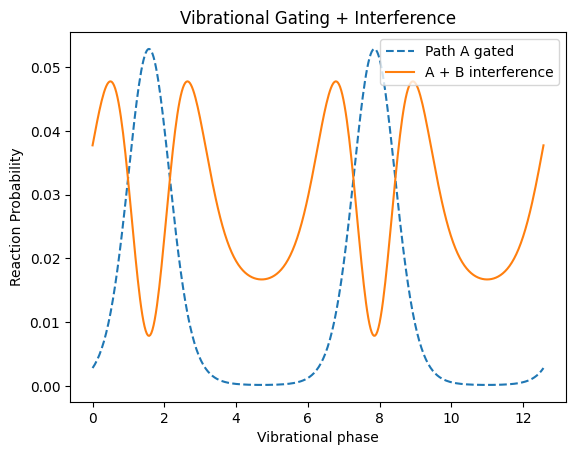

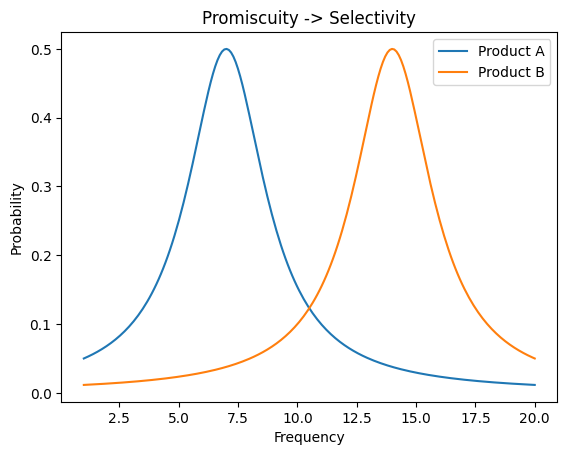

In [ ]:
# --- run_tunneling_demos.py ---
# Produces Figs 1-3: (1) TST vs tunneling,
# (2) vibrational gating + interference,
# (3) promiscuity -> selectivity tuning.

import numpy as np
import matplotlib.pyplot as plt

class QuantumEnzymeModel:
    def __init__(self, mass=1.0, hbar=1.0):
        self.m = mass
        self.hbar = hbar

    def _tunnel_probability(self, energy, barrier_height, barrier_width):
        if energy >= barrier_height or barrier_width <= 0:
            return 1.0
        kappa = np.sqrt(2*self.m*(barrier_height-energy))/self.hbar
        return np.exp(-2*kappa*barrier_width)

    def demo_tst_vs_tunneling(self):
        barrier_height, barrier_width = 10.0, 1.0
        E = np.linspace(0.1, 15, 200)
        p_tst = (E >= barrier_height).astype(float)
        p_qm  = [self._tunnel_probability(e, barrier_height, barrier_width) for e in E]

        plt.figure()
        plt.plot(E, p_tst, '--', label='Classical TST')
        plt.plot(E, p_qm,  '-',  label='Quantum tunneling')
        plt.axvline(barrier_height, color='k', ls=':', label='Barrier')
        plt.xlabel('Particle Energy'); plt.ylabel('Reaction Probability')
        plt.title('TST vs Quantum Tunneling')
        plt.legend()
        plt.show()


    def demo_gating_and_interference(self):
        E, V0, w0A, A, pB = 7.0, 10.0, 1.2, 0.6, 0.02
        ampB = np.sqrt(pB)
        t = np.linspace(0, 4*np.pi, 400)
        widthsA = w0A - A*np.sin(t)
        pA = [self._tunnel_probability(E, V0, w) for w in widthsA]
        dphi = 2*t
        tot = []
        for i, p in enumerate(pA):
            ampA = np.sqrt(max(p,0))
            aA = ampA * np.exp(1j*0.0)
            aB = ampB * np.exp(1j*dphi[i])
            tot.append(np.abs(aA+aB)**2)

        plt.figure()
        plt.plot(t, pA, '--', label='Path A gated')
        plt.plot(t, tot, '-', label='A + B interference')
        plt.xlabel('Vibrational phase'); plt.ylabel('Reaction Probability')
        plt.title('Vibrational Gating + Interference')
        plt.legend()
        plt.show()


    def demo_promiscuity_selectivity(self):
        def resp(freq,f0): return 0.5/(1+((freq-f0)/2.0)**2)
        freq = np.linspace(1, 20, 200)
        fA, fB = 7.0, 14.0
        pA = [resp(f,fA) for f in freq]
        pB = [resp(f,fB) for f in freq]

        plt.figure()
        plt.plot(freq, pA, '-', label='Product A')
        plt.plot(freq, pB, '-', label='Product B')
        plt.xlabel('Frequency'); plt.ylabel('Probability')
        plt.title('Promiscuity -> Selectivity')
        plt.legend()
        plt.show()

qe = QuantumEnzymeModel()
qe.demo_tst_vs_tunneling()
qe.demo_gating_and_interference()
qe.demo_promiscuity_selectivity()

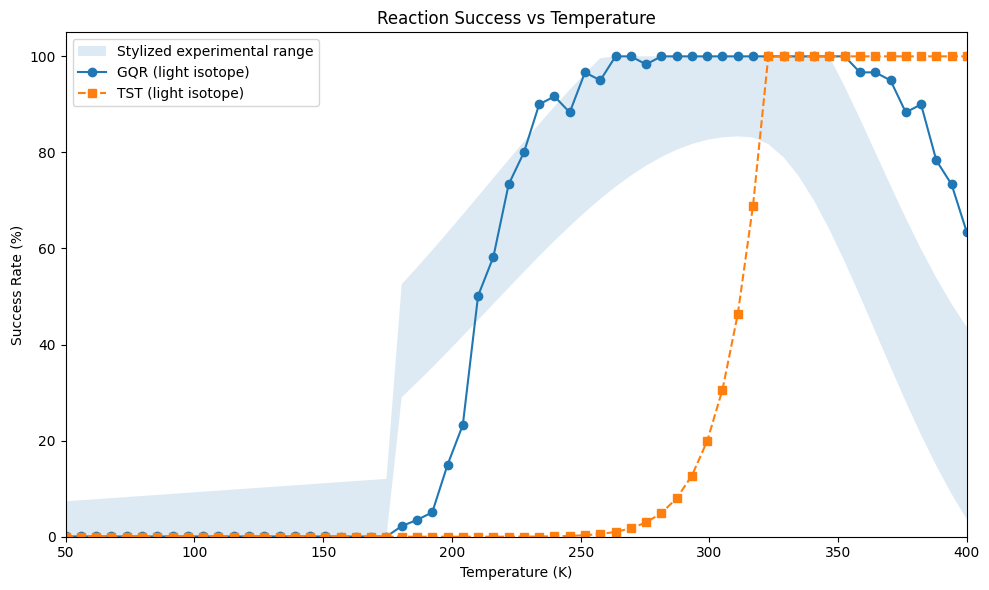

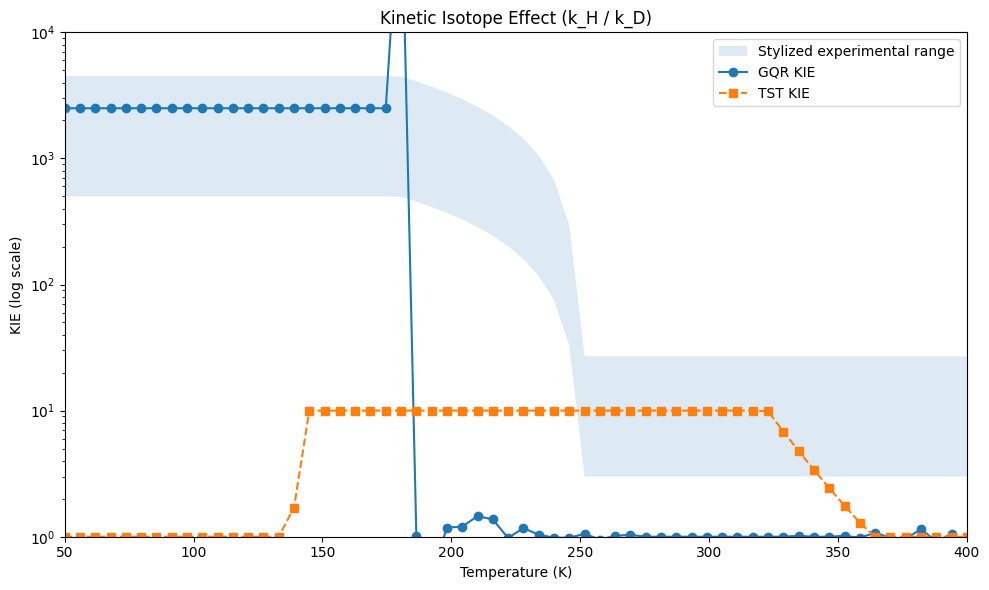

In [ ]:
# gqr_tst_kie_temperature.py
# Colab/Jupyter friendly; shows plots inline and also saves PNGs.

import numpy as np
import matplotlib.pyplot as plt

# ---------------- GQR model ----------------
class EnzymeGQR:
    """
    GQR: coherence-gated energy accumulation, isotope-dependent increments,
    threshold-triggered tunneling; blends low-T analytical plateaus with MC.
    """
    def __init__(self, catalytic_threshold=10.0, max_cycles=2000):
        self.catalytic_threshold = catalytic_threshold
        self.max_cycles = max_cycles
        self.optimal_temp = 310.0
        self.coherence_width = 70.0
        self.dissociation_factor = 0.03
        # Isotope dependence
        self.base_energy_increment = 1.1
        self.mass_effect_on_increment = 0.1
        self.kie_mass_factor_light = 1.0
        self.kie_mass_factor_heavy = 2.0
        # Low-T tunneling plateaus
        self.direct_tunnel_prob_light = 5e-4
        self.direct_tunnel_prob_heavy = 2e-7
        # Blend window
        self.transition_start = 150.0
        self.transition_end   = 220.0

    def run_single_monte_carlo_trial(self, isotope='light', T=310.0, rng=None):
        if rng is None:
            rng = np.random.default_rng()

        E = 0.0
        mf = self.kie_mass_factor_light if isotope == 'light' else self.kie_mass_factor_heavy
        coh = np.exp(-((T - self.optimal_temp)**2) / (2.0 * self.coherence_width**2))
        p_confirm = float(coh * 0.98)
        p_dissoc  = float(min(1.0, 0.002 * np.exp(self.dissociation_factor * abs(T - self.optimal_temp))))
        dE = float(self.base_energy_increment - (self.mass_effect_on_increment * mf))
        p_tunnel = float(0.98 ** mf)

        for _ in range(1, int(self.max_cycles) + 1):
            if rng.random() < p_confirm:
                E += dE
            else:
                if rng.random() < p_dissoc:
                    return 0.0  # dissociated
            if E >= self.catalytic_threshold:
                if rng.random() < p_tunnel:
                    return 1.0  # success
                E *= 0.8  # partial loss on failed attempt
        return 0.0

# ---------------- TST proxy ----------------
def tst_prob(isotope='light', T=310.0):
    Ea = 55.0       # kJ/mol
    R  = 8.314e-3   # kJ/(mol*K)
    A  = 8e8
    prob_floor = 1e-12
    kie = 1.0 if isotope == 'light' else 0.1  # crude proxy
    p = A * np.exp(-Ea / (R * T)) * kie
    return float(min(1.0, max(prob_floor, p)))

# ---------------- Stylized experimental bands ----------------
def exp_trends(T):
    peak = 315
    low_plateau = 0.005
    lw, rw = 100, 50
    rate = []
    for t in T:
        if t < 180:
            r = low_plateau
        elif t < peak:
            r = low_plateau + (1 - low_plateau) * np.exp(-((t - peak)**2) / (2.0 * lw**2))
        else:
            r = np.exp(-((t - peak)**2) / (2.0 * rw**2))
        rate.append(r)
    rate = np.array(rate)
    if np.max(rate) > 0:
        rate = rate / np.max(rate)
    err = 0.05 + (T/400.0) * 0.15
    rate_lo = np.clip(rate - err, 0, 1)
    rate_hi = np.clip(rate + err, 0, 1)

    # KIE band
    kie_loT, kie_hiT = 2500.0, 15.0
    t0, t1 = 180.0, 250.0
    kie = np.zeros_like(T, dtype=float)
    for i, t in enumerate(T):
        if t < t0:
            kie[i] = kie_loT
        elif t <= t1:
            f = (t - t0) / (t1 - t0)
            kie[i] = kie_loT * (1.0 - f) + kie_hiT * f
        else:
            kie[i] = kie_hiT
    kie_err = kie * 0.8
    kie_lo = np.clip(kie - kie_err, 0.1, None)
    kie_hi = kie + kie_err
    return (rate_lo, rate_hi), (kie_lo, kie_hi)

# ---------------- Main runner ----------------
def run_temperature_sweep(n_runs=50, seed=1234):
    rng = np.random.default_rng(seed)
    T = np.linspace(50, 400, 60)
    gqr = EnzymeGQR()

    gL, gH, tL, tH = [], [], [], []
    for t in T:
        # GQR
        if t <= gqr.transition_start:
            pL, pH = gqr.direct_tunnel_prob_light, gqr.direct_tunnel_prob_heavy
        else:
            L = [gqr.run_single_monte_carlo_trial('light', t, rng) for _ in range(n_runs)]
            H = [gqr.run_single_monte_carlo_trial('heavy', t, rng) for _ in range(n_runs)]
            pL, pH = float(np.mean(L)), float(np.mean(H))
            if t < gqr.transition_end:
                f = (t - gqr.transition_start) / (gqr.transition_end - gqr.transition_start)
                pL = (1 - f) * gqr.direct_tunnel_prob_light + f * pL
                pH = (1 - f) * gqr.direct_tunnel_prob_heavy + f * pH
        gL.append(pL)
        gH.append(pH)

        # TST
        tL.append(tst_prob('light', t))
        tH.append(tst_prob('heavy', t))

    return T, np.array(gL), np.array(gH), np.array(tL), np.array(tH)

def make_plots():
    T, gL, gH, tL, tH = run_temperature_sweep(n_runs=60, seed=42)
    (rate_lo, rate_hi), (kie_lo, kie_hi) = exp_trends(T)

    # Fig 1: Success vs Temperature
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.fill_between(T, rate_lo*100, rate_hi*100, alpha=0.15, label='Stylized experimental range')
    ax1.plot(T, gL*100, 'o-', label='GQR (light isotope)')
    ax1.plot(T, tL*100, 's--', label='TST (light isotope)')
    ax1.set_title('Reaction Success vs Temperature')
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_xlim(50, 400)
    ax1.set_ylim(0, 105)
    ax1.legend()
    fig1.tight_layout()
    fig1.savefig('fig_rate_vs_T.png', dpi=300, bbox_inches='tight')

    # Fig 2: KIE (k_H / k_D)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    kie_gqr = np.divide(gL, gH, out=np.ones_like(gL), where=(gH > 0))
    kie_tst = np.divide(tL, tH, out=np.ones_like(tL), where=(tH > 0))
    ax2.fill_between(T, kie_lo, kie_hi, alpha=0.15, label='Stylized experimental range')
    ax2.plot(T, kie_gqr, 'o-', label='GQR KIE')
    ax2.plot(T, kie_tst, 's--', label='TST KIE')
    ax2.set_yscale('log')
    ax2.set_title('Kinetic Isotope Effect (k_H / k_D)')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('KIE (log scale)')
    ax2.set_xlim(50, 400)
    ax2.set_ylim(1, 1e4)
    ax2.legend()
    fig2.tight_layout()
    fig2.savefig('fig_KIE_vs_T.png', dpi=300, bbox_inches='tight')

    # Show both figures inline
    plt.show()

if __name__ == "__main__":
    make_plots()